# Project 3

## Names: 

- Krish Engineer (ke7466)
- Rudraksh Garg (rg44778)
-  Ryan Lee (rl32227)
- Samarth Mishra (sm79247)


In [110]:
import gurobipy as gp
import numpy as np
import pandas as pd

## Reading training and test csv files here

In [111]:
train_df = pd.read_csv('training_data.csv')
train_df.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [112]:
test_df = pd.read_csv('test_data.csv')
test_df.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


## Defining a function to compute Beta coefficients ('TimeLimit' variable defined in line 40)

In [113]:
def get_betas(q_matrix, linear_term, k, M, m):
    
#   Setting up A Matrix

    A = np.zeros((2*m+1,2*m+1)) # Inititalizing A matrix
    
    A[0,-m:] = np.ones(m) # Constraint on z variables

    # Big M Constraints 
    j=0
    for i in range(1,m+1):
        A[i,i] = 1
        A[i,-m+j] = -M
        j = j+1
    d=0
    for a,c in zip(range(i+1,2*m+1), range(1,m+1)):
        A[a,c] = 1
        print()
        A[a,-m+d] = M
        d = d + 1
        
    # Setting up b matrix
    
    b = [0]*(2*m+1)
    b[0] = k
    b_arr = np.array(b)
    
    # Setting up sense matrix
    sense = ['<']*(m+1)
    sense.extend(['>']*(m))
    sense_arr = np.array(sense)
    
    # Running the optimzation model to compute beta coefficients
    model = gp.Model()
    mod_x = model.addMVar(2*m+1,vtype=np.array(['C']*(m+1) + ['B']*m), lb=np.array([np.NINF]+[-M]*(m)+ [0]*m))
    mod_con = model.addMConstr(A, mod_x, sense_arr, b_arr)

    #setting obj
    model.setMObjective(q_matrix,linear_term,0,sense=gp.GRB.MINIMIZE)
    model.Params.TimeLimit = 3600
    #model.setParam('IntFeasTol', 1e-9) # binary var can be non zero 
    model.Params.OutputFlag = 0 
    model.optimize()
    my_coeffs = mod_x.x
    
    return (model.objVal, my_coeffs)

### Defining functions to compute Q and c matrices for the MIQP

In [114]:
## Creating a function that outputs the Q matrix
def create_qmatrix(x_arr,m):
    rows = 2*m+1
    cols = 2*m+1
    q_matrix = np.zeros((rows,cols))
    q_matrix[:m+1,:m+1] = x_arr.T @ x_arr
    return q_matrix

## Creating a function that outputs the linear term    
def create_linearTerm(x_arr,y_arr,m):
    t2 = (-2)* y_arr.T @ x_arr
    linear_term = np.pad(t2, (0, m), 'constant') 
    return linear_term

## Running 10-fold Cross-Validation for different values of k

In [6]:
m = train_df.iloc[:,1:].shape[1]
ndata = len(train_df)
folds = 10
total_rows = [i for i in range(ndata)]
mse_k_dict = {}

# Running 10-fold CV for different values of k
for k in range(5,51,5): 
    shuffle = np.random.choice(range(ndata),size=ndata,replace=False)
    mse_list = []
    
    for j in range(folds): # Runnning different folds
        data_size = int(ndata/folds)
        
        # Defining training and validation sets for each fold
        val = total_rows[j*(data_size):(j+1)*data_size]  
        train_rows = list(set(total_rows) - set(val))        
        validation_set = train_df.iloc[shuffle[val],:]
        train_set = train_df.iloc[shuffle[train_rows],:]
        
        Xtrain = train_set.iloc[:,1:]
        idx = 0
        n = Xtrain.shape[0]
        new_col = [1]* n     
        Xtrain.insert(loc=idx, column='X0', value=new_col)
        x_arr = Xtrain.to_numpy()
       
        q_matrix = create_qmatrix(x_arr,m) # Computing Q matrix using training data

        y_arr = train_set['y'].to_numpy() 
        
        linear_term = create_linearTerm(x_arr,y_arr,m) # Computing matrix for linear term using training data
    
        coeffs = get_betas(q_matrix, linear_term, k, 100,m)[1] # Computing Beta coefficients using training data      
        
        # Calculating SSE and MSE for the validation data
        sse_perfold =0
        for x,y in validation_set.iterrows():
            beta0 = coeffs[0] # Intercept term                          
            sse_perfold += np.transpose((y[1:] @ coeffs[1:m+1])+beta0 - y[0]) * ((y[1:] @ coeffs[1:m+1])+beta0 - y[0])
        
        mse_perfold = sse_perfold/len(validation_set) 
        mse_list.append(mse_perfold)

    
    final_MSE_10_fold = sum(mse_list)/folds
   
    mse_k_dict[k]= final_MSE_10_fold # Storing the test MSE values from 10-fold CV for different values of k 



















































Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-22
Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600

















































































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


















































Set parameter TimeLimit to value 3600


## Test MSE from 10-fold CV for different values of k

In [7]:
mse_df_10_fold = pd.DataFrame()
mse_df_10_fold['Value of k'] = mse_k_dict.keys()
mse_df_10_fold['MSE'] = mse_k_dict.values()

# Show dataframe with MSE values
mse_df_10_fold

,Value of k,MSE
0,5,3.959193
1,10,2.805040
2,15,3.134713
3,20,3.178051
4,25,3.451272
5,30,3.368715
6,35,3.320179
7,40,3.467398
8,45,3.465303
9,50,3.415552


## k with the smallest cross validation error

In [8]:
optimal_k=min(mse_k_dict.items(), key=lambda x: x[1])[0]
print('Optimal k :',optimal_k)

Optimal k : 10


## Running the MIQP model for k=10 on entire training data

In [115]:
m = train_df.iloc[:,1:].shape[1]
Xtrain = train_df.iloc[:,1:]
idx = 0
n = Xtrain.shape[0]
new_col = [1]* n     
Xtrain.insert(loc=idx, column='X0', value=new_col)
x_arr = Xtrain.to_numpy()

# Computing Q matrix using entire training data for k=10
q_matrix = create_qmatrix(x_arr,m)

y_arr = train_df['y'].to_numpy()

# Computing linear term using entire training data for k=10
linear_term = create_linearTerm(x_arr,y_arr,m)

# Computing Beta coefficients using entire training data for k=10
coeffs = get_betas(q_matrix, linear_term, 10,100,m)[1]



















































Set parameter TimeLimit to value 3600


## Beta Coefficients for k= 10 (running MIQP model on entire training data)

In [116]:
coeffs[:m+1]

array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

## Calculating Train MSE for k=10 (running MIQP model on entire training data)

In [117]:
sse_optimal =0
predicted_y_train=[]
for x,y in train_df.iterrows():
    beta0 = coeffs[0]                         
    # calculate the SSE for holdout set
    sse_optimal += np.transpose((y[1:] @ coeffs[1:m+1])+beta0 - y[0]) * ((y[1:] @ coeffs[1:m+1])+beta0 - y[0])
    pred_y=(y[1:] @ coeffs[1:m+1])+beta0
    predicted_y_train.append(pred_y)
mse_MIQP_train = sse_optimal/len(train_df)
print('Training MSE for k=10:',mse_MIQP_train)

Training MSE for k=10: 2.391985266291456


## Calculating Test MSE for k=10 (running MIQP model on entire training data)

In [118]:
sse_optimal =0
predicted_y=[]
for x,y in test_df.iterrows():
    beta0 = coeffs[0]                         
    # calculate the SSE for holdout set
    sse_optimal += np.transpose((y[1:] @ coeffs[1:m+1])+beta0 - y[0]) * ((y[1:] @ coeffs[1:m+1])+beta0 - y[0])
    pred_y=(y[1:] @ coeffs[1:m+1])+beta0
    predicted_y.append(pred_y)
mse_MIQP_test = sse_optimal/len(test_df)
print('Test MSE for k=10:',mse_MIQP_test)

Test MSE for k=10: 2.336543964552526


## Predicted y for Test Set

In [119]:
## Actual vs Predicted y
df_prediction=pd.DataFrame()
df_prediction['Actual y']=test_df['y'].to_numpy()
df_prediction['Predicted y']=predicted_y
df_prediction

,Actual y,Predicted y
0,7.107949,6.179859
1,5.796272,5.095243
2,1.598651,3.285595
3,2.532953,3.758485
4,0.590685,-0.332975
5,-6.108818,-5.142737
6,-1.993021,-3.144544
7,-1.982904,-1.238063
8,0.134034,1.385111
9,-0.728690,-0.441739


## Lasso Regression using 10-fold CV

In [120]:
y_train = train_df['y'].to_numpy()
X_train = train_df.drop(['y'], axis=1).to_numpy()

In [121]:
y_test = test_df['y'].to_numpy()
X_test = test_df.drop(['y'], axis=1).to_numpy()

In [122]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(cv=10,random_state=0,normalize=True)
lasso_model.fit(X_train, y_train)

C:\Users\smjoh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


LassoCV(cv=10, normalize=True, random_state=0)

Best Lambda Value

In [123]:
lasso_model.alpha_

0.0057453437864455085

## Beta Coefficients

In [124]:
print("Intercept: ", lasso_model.intercept_)
print("Beta Coefficients:",lasso_model.coef_)

Intercept:  1.0061963544057866
Beta Coefficients: [-0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -2.11561506  0.         -0.06043079 -0.
 -0.         -0.         -0.41674549 -0.18155256  0.          0.
 -0.          0.          0.         -0.19710223 -1.3655275   0.73510021
 -0.         -1.30018578  0.          0.          0.06390289  0.
 -0.          0.         -0.10737966  0.25392747  0.02138366  0.
  0.          0.         -0.21159473  0.         -0.          0.
  0.          0.01152326  1.53171531 -0.01408773  0.6504778  -0.09757869
  0.          0.        ]


## Predicting y for Training Set

In [125]:
y_pred_train = lasso_model.predict(X_train)

## Predicting y for Test Set

In [126]:
y_pred = lasso_model.predict(X_test)
df_prediction_lasso=pd.DataFrame()
df_prediction_lasso['Actual y']=y_test
df_prediction_lasso['Predicted y']=y_pred
df_prediction_lasso

,Actual y,Predicted y
0,7.107949,6.038252
1,5.796272,4.864944
2,1.598651,3.181195
3,2.532953,3.531681
4,0.590685,-0.458115
5,-6.108818,-4.851936
6,-1.993021,-2.791733
7,-1.982904,-1.446001
8,0.134034,1.395798
9,-0.728690,-0.178812


Training MSE for Lasso Regression

In [127]:
from sklearn.metrics import mean_squared_error
mse_tr = mean_squared_error(y_train, y_pred_train)
mse_tr

2.400989795079007

Test MSE for Lasso Regression

In [128]:
mse_test = mean_squared_error(y_test, y_pred)
mse_test

2.3597086675768337

## Specific Plots/ Graphs for Report

[Text(0, 0, 'Lasso'), Text(1, 0, 'MIQP')]

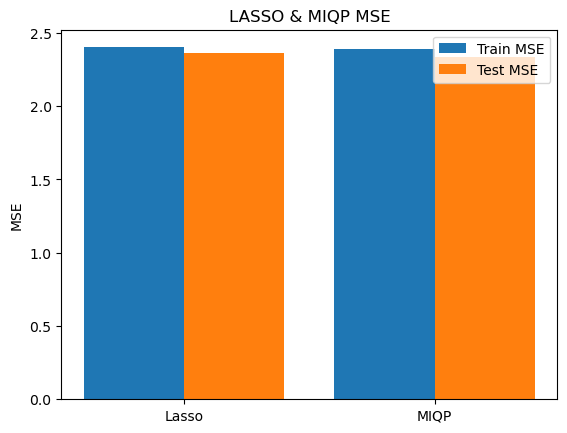

In [129]:
import matplotlib.pyplot as plt
import statistics as s

train_list = [mse_tr,mse_MIQP_train]
test_list = [mse_test, mse_MIQP_test]

fig, ax = plt.subplots()
x = np.arange(2)
width = 0.40
rects1 = ax.bar(x-width/2,train_list,width,label = 'Train MSE')
rects2 = ax.bar(x+width/2,test_list,width, label = 'Test MSE')
plt.title('LASSO & MIQP MSE')
plt.ylabel('MSE')
plt.legend()
ax.set_xticks([0, 1])
ax.set_xticklabels(['Lasso', 'MIQP'])

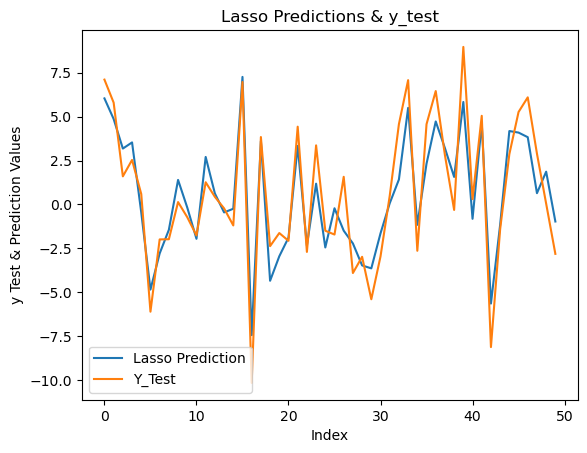

In [130]:
plt.plot(range(len(y_pred)), y_pred, label = 'Lasso Prediction')
plt.plot(range(len(y_pred)), y_test, label = 'Y_Test')

plt.xlabel('Index')
plt.ylabel('y Test & Prediction Values')
plt.title('Lasso Predictions & y_test')
plt.legend()

plt.show()

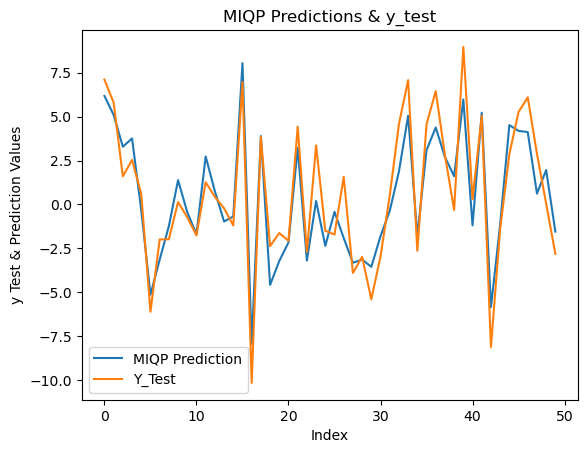

In [131]:
plt.plot(range(len(y_pred)), predicted_y, label = 'MIQP Prediction')
plt.plot(range(len(y_pred)), y_test, label = 'Y_Test')
plt.xlabel('Index')
plt.ylabel('y Test & Prediction Values')
plt.title('MIQP Predictions & y_test')
plt.legend()

plt.show()

In [132]:
lasso_res = []
MIQP_res = []

for i in range(len(y_pred)):
    lasso_diff = (y_pred[i] - y_test[i])
    MIQP_diff = (predicted_y[i] - y_test[i])
    lasso_res.append(lasso_diff)
    MIQP_res.append(MIQP_diff)

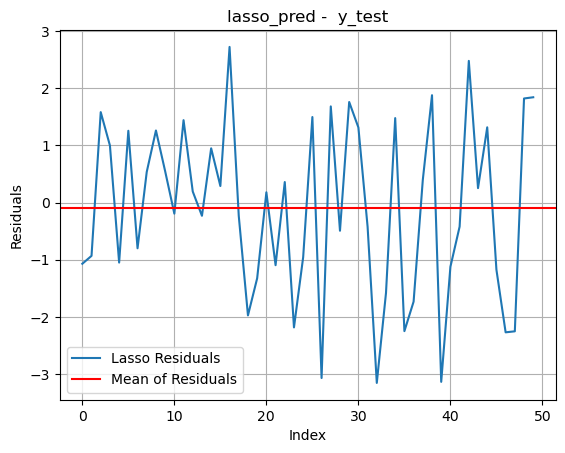

In [133]:
plt.plot(range(len(y_pred)),lasso_res , label = 'Lasso Residuals')
lasso_res_m = s.mean(lasso_res)
plt.axhline(y = lasso_res_m, color = 'r', linestyle = '-',label = 'Mean of Residuals')
plt.title('lasso_pred -  y_test')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.legend()
plt.grid()

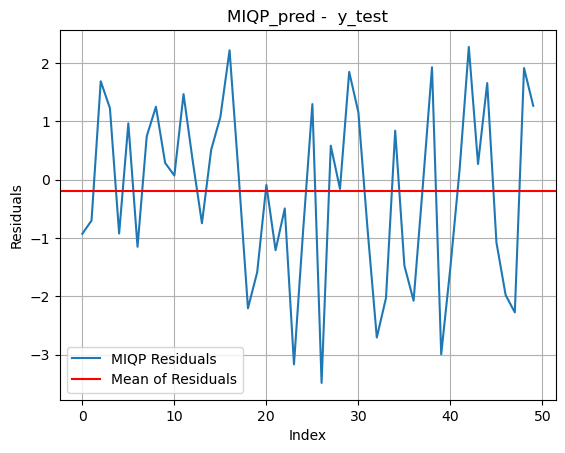

In [134]:
plt.plot(range(len(y_pred)),MIQP_res, label = 'MIQP Residuals')
MIQP_res_m = s.mean(MIQP_res)
plt.axhline(y = MIQP_res_m, color = 'r', linestyle = '-',label = 'Mean of Residuals')
plt.title('MIQP_pred -  y_test')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.legend()
plt.grid()

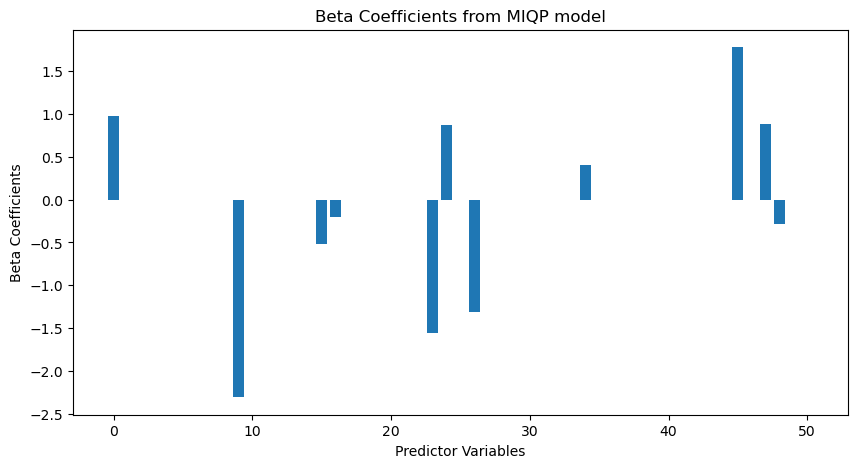

In [135]:
fig = plt.figure(figsize = (10, 5))
x_ind = np.arange(m+1)
plt.bar(x_ind,coeffs[:m+1])
plt.xlabel("Predictor Variables")
plt.ylabel("Beta Coefficients")
plt.title("Beta Coefficients from MIQP model")
plt.show()

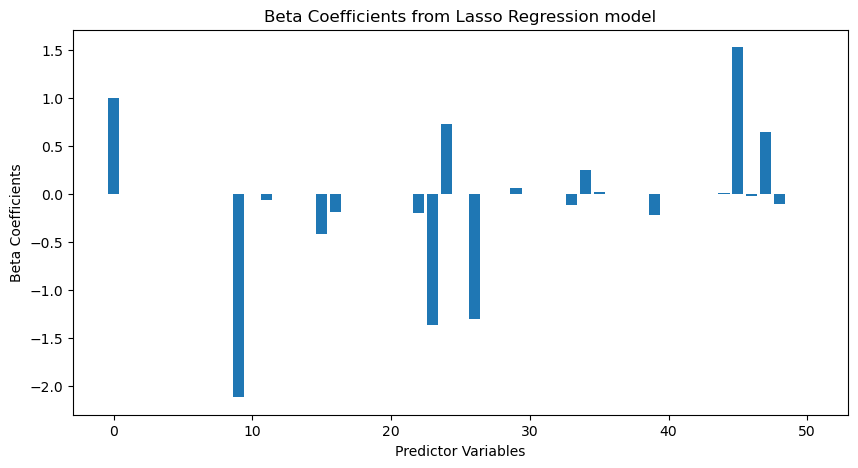

In [136]:
lasso_coef=np.insert(lasso_model.coef_,0,lasso_model.intercept_)
fig = plt.figure(figsize = (10, 5))
x_ind = np.arange(m+1)
plt.bar(x_ind,lasso_coef)
plt.xlabel("Predictor Variables")
plt.ylabel("Beta Coefficients")
plt.title("Beta Coefficients from Lasso Regression model")
plt.show()